# How could Olist increase its profit? 

Analysis by Oscar Schraenkler

## Problem Statement

❓ How many underperforming sellers should Olist remove to improve its profit, given that it has:

- Some revenues per sellers per months
- Some revenues per orders
- Some reputation costs (estimated) per bad reviews
- Some operational costs of IT system that grows with number of orders, but not linearly (scale effects)

## P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

## Imports & Loading Data

### Imports

In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [54]:
from olist.seller import Seller
from olist.data import Olist
data = Olist().get_data() #dictionary with all tables from the dataset as DataFrames, stored in data.py
sellers = Seller().get_training_data() #DataFrame prepared for this analysis, stored in seller.py

### Displaying dataframe

In [53]:
display(sellers.head(5))
display(sellers.describe())

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.725000,0.050000,4.55
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,1.000000,0.000000,5.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,1.000000,0.000000,5.00
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,0.000000,1.000000,1.00


,delay_to_carrier,wait_time,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_five_stars,share_of_one_stars,review_score
count,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,0.385636,12.139417,6.025615,33.650489,37.897203,1.157337,4568.852187,0.595077,0.120886,4.101513
std,2.295812,7.069233,5.994211,107.182856,121.514362,0.439557,14191.836779,0.278763,0.188857,0.801517
min,0.000000,1.214178,0.000000,1.000000,1.000000,1.000000,6.500000,0.000000,0.000000,1.000000
25%,0.000000,8.287658,1.000000,2.000000,3.000000,1.000000,239.850000,0.493022,0.000000,3.846154
50%,0.000000,11.115143,4.000000,7.000000,8.000000,1.000000,896.000000,0.600000,0.058824,4.210526
75%,0.000000,14.231984,10.000000,23.000000,26.000000,1.142857,3583.995000,0.750000,0.159043,4.626453
max,45.434039,189.863160,23.000000,1854.000000,2033.000000,15.000000,229472.630000,1.000000,1.000000,5.000000


We can see that the Sellers dataframe consists of 2967 entries representing unique sellers on the Olist platform with the following features:
  
| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `seller_id` 	| str 	| the id of the seller **UNIQUE** 	|
| `seller_city` 	| str 	| the city where seller is located 	|
| `seller_state` 	| str 	| the state where seller is located 	|
| `delay_to_carrier` 	| float 	| returns 0 if the order is delivered before the shipping_limit_date, otherwise the value of the delay 	|
| `wait_time` 	| float 	| average wait_time (duration of deliveries) per seller 	|
| `date_first_sale` 	| datetime 	| date of the first sale on Olist 	|
| `date_last_sale` 	| datetime 	| date of the last sale on Olist 	|
| `months_on_olist` 	| float 	| round number of months  on Olist	|
| `share_of_five_stars` 	| float 	| share of five-star reviews for orders in which the seller was involved 	|
| `share_of_one_stars` 	| float 	| share of one-star reviews for orders in which the seller was involved 	|
| `review_score` 	| float 	| average review score for orders in which the seller was involved 	|
| `n_orders` 	| int 	| number of unique orders the seller was involved with 	|
| `quantity` 	| int 	| total number of items sold by this seller 	|
| `quantity_per_order` 	| float 	| average number of items per order for this seller 	|
| `sales` 	| float 	| total sales associated with this seller (excluding freight value) in BRL 	|  

## Data Preparation

For each seller, compute the cumulated:
- `revenue` the seller brings to Olist: sum of subscription and sales fees revenues.
- `cost_of_reviews` associated with all the seller's bad reviews: sum of costs associated with bad reviews.
- resulting `profits`: revenues - costs.
- `n_products`, the number of products the seller has sold: taken from the quantity colum of the sellers DataFrame.

### Calculating revenue per seller

In [13]:
seller_df = pd.DataFrame()
seller_df['seller_id']=sellers['seller_id']
seller_df['revenue']=((.1 * sellers['sales'])+(80*sellers['months_on_olist']))
seller_df

,seller_id,revenue
0,3442f8959a84dea7ee197c632cb2df15,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,16.799
...,...,...
2962,98dddbc4601dd4443ca174359b237166,15.800
2963,f8201cab383e484733266d1906e2fdfa,1208.900
2964,74871d19219c7d518d0090283e03c137,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,349.700


### Calculating cost of reviews per seller

In [14]:
order_sellers = data['order_items'][['order_id','seller_id']].drop_duplicates()
tmp = order_sellers.merge(data['order_reviews'], on='order_id')

tmp['cost_of_reviews'] = tmp.review_score.map({1: 100,
2: 50,
3: 40,
4: 0,
5: 0,})

tmp = tmp[['seller_id','cost_of_reviews']].groupby('seller_id',as_index=False).agg({'cost_of_reviews':'sum'})

seller_df = tmp.merge(seller_df, on='seller_id')
seller_df

,seller_id,cost_of_reviews,revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,100,348.500
1,001cca7ae9ae17fb1caed9dfb1094831,3560,3868.003
2,002100f778ceb8431b7a1020ff7ab48f,1110,683.450
3,003554e2dce176b5555353e4f3555ac8,0,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,2430,3171.271
...,...,...,...
2962,ffc470761de7d0232558ba5e786e57b7,260,644.901
2963,ffdd9f82b9a447f6f8d4b91554cc7dd3,190,1650.120
2964,ffeee66ac5d5a62fe688b9d26f83f534,200,743.986
2965,fffd5413c0700ac820c7069d66d98c89,1360,1946.230


### Calculating profit per seller

In [15]:
seller_df['profits'] = seller_df['revenue']-seller_df['cost_of_reviews']
seller_df

,seller_id,cost_of_reviews,revenue,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,100,348.500,248.500
1,001cca7ae9ae17fb1caed9dfb1094831,3560,3868.003,308.003
2,002100f778ceb8431b7a1020ff7ab48f,1110,683.450,-426.550
3,003554e2dce176b5555353e4f3555ac8,0,12.000,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,2430,3171.271,741.271
...,...,...,...,...
2962,ffc470761de7d0232558ba5e786e57b7,260,644.901,384.901
2963,ffdd9f82b9a447f6f8d4b91554cc7dd3,190,1650.120,1460.120
2964,ffeee66ac5d5a62fe688b9d26f83f534,200,743.986,543.986
2965,fffd5413c0700ac820c7069d66d98c89,1360,1946.230,586.230


### Getting the number of products each seller has sold

In [56]:
num_of_products = sellers[['seller_id','quantity']].rename(columns={'quantity': 'n_products'}) #isolating number of products by seller id
num_of_products

,seller_id,n_products
0,3442f8959a84dea7ee197c632cb2df15,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,41
2,ce3ad9de960102d0677a81f5d0bb7b2d,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,1
4,51a04a8a6bdcb23deccc82b0b80742cf,1
...,...,...
2962,98dddbc4601dd4443ca174359b237166,2
2963,f8201cab383e484733266d1906e2fdfa,10
2964,74871d19219c7d518d0090283e03c137,7
2965,e603cf3fec55f8697c9059638d6c8eb5,11


### Displaying data in one table

In [57]:
seller_df = num_of_products.merge(seller_df, on='seller_id') #merging number of products on seller_df
df_sorted = seller_df.sort_values(by='profits') #sorting sellers by lowest profits to highest.

In [55]:
display(df_sorted.head())
display(df_sorted.shape)

,seller_id,n_products,cost_of_reviews,revenue,profits
769,6560211a19b47992c3666cc44a7e94c0,2033,35290,13770.483,-21519.517
2358,4a3ca9315b744ce9f8e9374361493884,1987,39400,21647.292,-17752.708
1357,cc419e0650a3c5ba77189a1882b7556a,1775,29530,11948.842,-17581.158
945,ea8482cd71df3c1969d7b9473ff13abc,1203,20220,4677.752,-15542.248
315,8b321bb669392f5163d04c59e235e066,1018,15440,2553.569,-12886.431


(2967, 5)

## Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

𝐼𝑇_𝑐𝑜𝑠𝑡𝑠=𝛼∗𝑛_𝑠𝑒𝑙𝑙𝑒𝑟𝑠⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√+𝛽∗𝑛_𝑝𝑟𝑜𝑑𝑢𝑐𝑡𝑠⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√ 
Olist's data team gave us the following values for these scaling parameters:

𝛼=3157.27 
𝛽=978.23

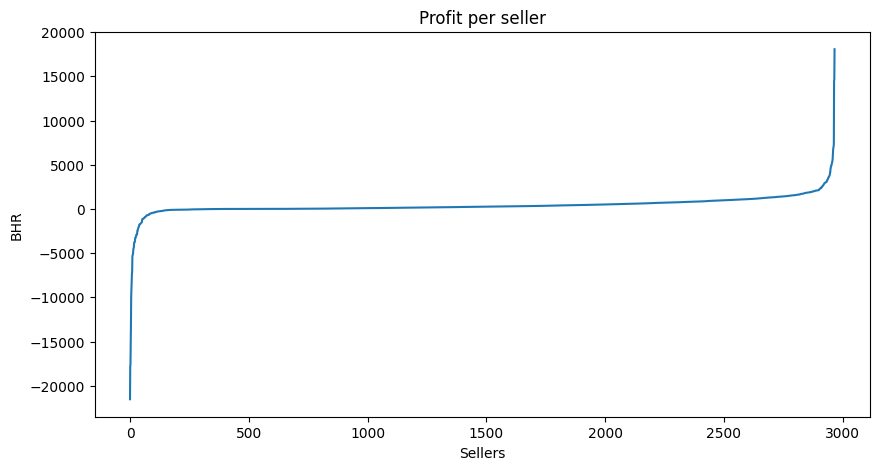

In [20]:
sorted_df = seller_df.sort_values(by='profits')[['profits', 'n_products', 'revenue']].reset_index()
sorted_df.head()

plt.figure(figsize=(10,5))
sorted_df.profits.plot()
plt.title('Profit per seller')
plt.xlabel('Sellers')
plt.ylabel('BHR');

- Small amount of worst sellers contribute to large proportion of losses
- Small amount of best sellers contribute to large proportion of profits
- Most sellers do not contribute much profit or losses

In [21]:
def it_costs(n_sellers,n_products):
    return round(3157.27*(np.sqrt(n_sellers))+978.23*(np.sqrt(n_products)))


In [22]:
df_copy = sorted_df

df_copy

,index,profits,n_products,revenue
0,769,-21519.517,2033,13770.483
1,2358,-17752.708,1987,21647.292
2,1357,-17581.158,1775,11948.842
3,945,-15542.248,1203,4677.752
4,315,-12886.431,1018,2553.569
...,...,...,...,...
2962,2830,7071.119,542,14571.119
2963,2151,7288.455,175,8808.455
2964,534,14494.203,586,21004.203
2965,67,14623.187,340,19323.187


## What happens to profits when we remove the worst sellers one by one?

In [23]:
# save all results in these lists
total_profit = []
num_sellers = []
IT_costs = []
profits_sellers = []
sellers_loop = df_copy
# loop over range of sellers while removing one row each time
for i in range(len(df_copy['profits'])):
    total_profit.append(df_copy.iloc[i:]['profits'].sum() \
        - it_costs(df_copy.iloc[i:]['profits'].count(), df_copy.iloc[i:]['n_products'].sum()))
    num_sellers.append(df_copy.iloc[i:]['profits'].count())
    IT_costs.append(it_costs(df_copy.iloc[i:]['profits'].count(), df_copy.iloc[i:]['n_products'].sum()))
    profits_sellers.append(df_copy.iloc[i:]['profits'].sum())

In [24]:
#total_profit
#sellers
#IT_costs
#profits_sellers
#sellers_loop

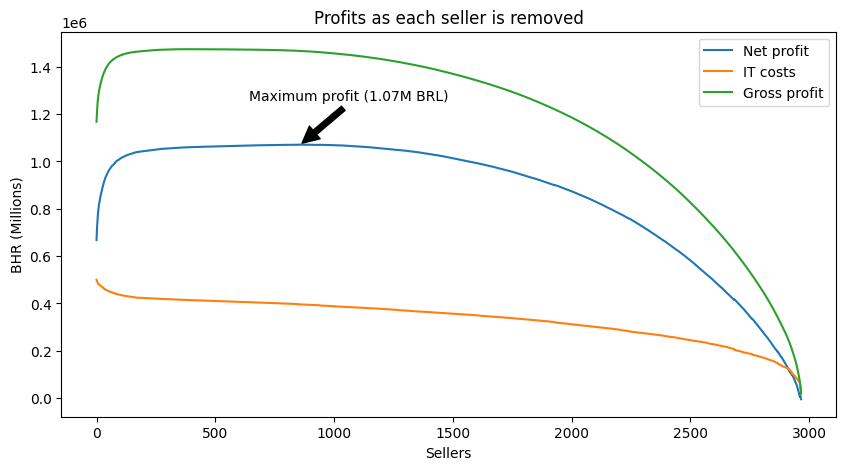

In [25]:
plt.figure(figsize=(10,5))
plt.plot(total_profit, label='Net profit')
plt.plot(IT_costs, label='IT costs')
plt.plot(profits_sellers, label='Gross profit')
plt.title('Profits as each seller is removed')
plt.xlabel('Sellers')
plt.ylabel('BHR (Millions)')
plt.annotate('Maximum profit (1.07M BRL)',
            xy=(855, 1068160), xycoords='data',
            xytext=(0.5, 0.85), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
plt.legend();

- To maximize profit, Olist should have removed 856 or 29% of its lowest rated sellers.
- According to our model this would have saved Olist 0.4M BRL over the analysis period.
- Profits would have been 1.07M BRL, a 160.4% change from the previous 0.67M profits.

In [26]:
sellers_to_remove = total_profit.index(np.max(total_profit))+1
max_profit = np.max(total_profit)
current_profit = df_copy['profits'].sum()-it_costs(df_copy['profits'].count(), df_copy['n_products'].sum())
ratio_sellers_to_remove = sellers_to_remove/len(num_sellers)
print(f'To maximize profit, olist should remove {sellers_to_remove} or {round(ratio_sellers_to_remove*100)}% of its lowest rated sellers.')
print(f'According to our model this would have saved olist {round(max_profit) - round(current_profit)} BRL over the analysis period.')
print(f'Profits would have been {max_profit} BRL, a {round((max_profit/current_profit)*100,1)}% change from the previous profit {current_profit}.')


To maximize profit, olist should remove 856 or 29% of its lowest rated sellers.
According to our model this would have saved olist 403367 BRL over the analysis period.
Profits would have been 1070976.411 BRL, a 160.4% change from the previous profit 667609.4440000001.


In [27]:
worst_sellers = df_sorted[0:856]
best_sellers = df_sorted[855:]
worst_sellers = worst_sellers.merge(sellers[['wait_time','months_on_olist','seller_id']], on='seller_id')
best_sellers = best_sellers.merge(sellers[['wait_time','months_on_olist','seller_id']], on='seller_id')

## Analysis of the 856 worst sellers

In [28]:
worst_seller_stats = worst_sellers.describe()

def highlight_cols(s):
    return 'background-color: % s' % 'yellow'

worst_seller_stats.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['wait_time']])


,n_products,cost_of_reviews,revenue,profits,wait_time,months_on_olist
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,54.533879,937.172897,587.551043,-349.621854,12.732937,2.449766
std,199.046990,3196.917258,1872.064043,1591.883611,10.292798,5.125996
min,1.000000,0.000000,0.650000,-21519.517000,1.214178,0.000000
25%,1.000000,0.000000,7.990000,-86.550000,7.134586,0.000000
50%,2.000000,40.000000,19.985000,2.545000,10.970185,0.000000
75%,8.000000,200.000000,194.916750,13.015000,14.995574,2.000000
max,2033.000000,39400.000000,21647.292000,48.660000,189.863160,23.000000


In [29]:
best_seller_stats = best_sellers.describe()

best_seller_stats.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['wait_time']])

,n_products,cost_of_reviews,revenue,profits,wait_time,months_on_olist
count,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000
mean,31.137784,386.377841,1080.948585,694.570744,11.896798,7.472538
std,67.394274,887.414020,1544.629957,926.035035,5.207038,5.707309
min,1.000000,0.000000,48.900000,48.660000,2.154711,0.000000
25%,5.000000,40.000000,314.132250,216.769750,8.655942,3.000000
50%,11.000000,140.000000,683.544000,451.336500,11.158848,6.000000
75%,30.000000,390.000000,1366.255000,907.412000,13.977671,11.000000
max,1171.000000,17480.000000,24387.263000,18067.605000,66.754657,23.000000


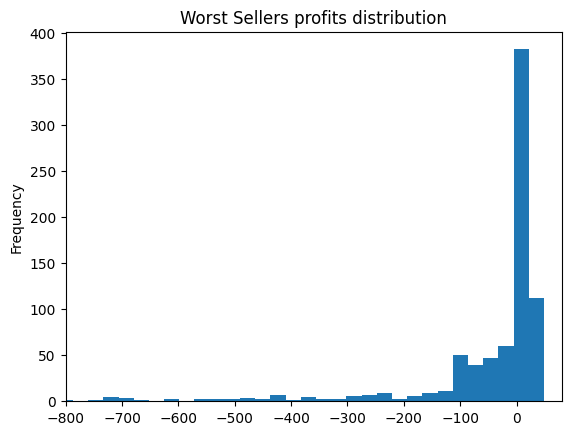

In [30]:
worst_sellers['profits'].plot(kind='hist',bins=800,xlim=(-800,80),title='Worst Sellers profits distribution');
plt.show()


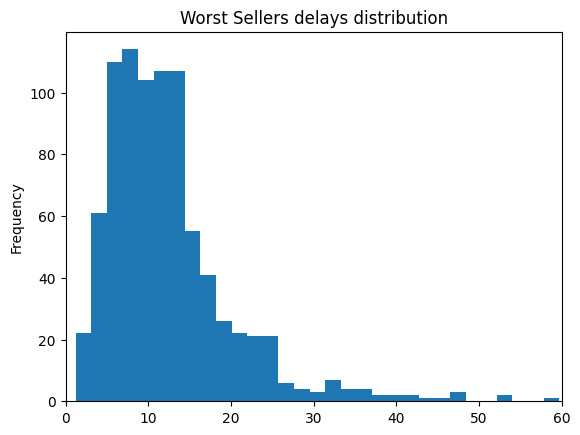

In [31]:
worst_sellers['wait_time'].plot(kind='hist',bins=100,xlim=(0,60),title='Worst Sellers delays distribution');
plt.show()

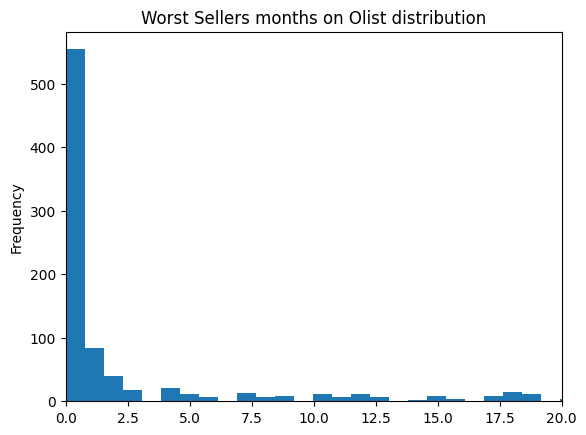

In [32]:
worst_sellers['months_on_olist'].plot(kind='hist',bins=30,xlim=(0,20),title='Worst Sellers months on Olist distribution');

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

In [42]:
orders = Order().get_training_data(with_distance_seller_customer=True)
orders

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.130333
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.800366
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,30.174037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08,69.481037
95876,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10,474.098245
95877,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02,968.051192
95878,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18,370.146853


In [34]:
lst = [
 'wait_time',
 'delay_vs_expected',
 'number_of_products',
 'number_of_sellers',
 'price',
 'freight_value',
 'distance_seller_customer']
orders1 = orders[lst]
orders1

,wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,8.436574,0.0,1,1,29.99,8.72,18.063837
1,13.782037,0.0,1,1,118.70,22.76,856.292580
2,9.394213,0.0,1,1,159.90,19.22,514.130333
3,13.208750,0.0,1,1,45.00,27.20,1822.800366
4,2.873877,0.0,1,1,19.90,8.72,30.174037
...,...,...,...,...,...,...,...
95875,8.218009,0.0,1,1,72.00,13.08,69.481037
95876,22.193727,0.0,1,1,174.90,20.10,474.098245
95877,24.859421,0.0,1,1,205.99,65.02,968.051192
95878,17.086424,0.0,2,1,359.98,81.18,370.146853


In [35]:
orders_scaled= orders1.copy()

for feature in orders_scaled.columns:
    mu= orders1[feature].mean()
    sigma= orders1[feature].std()
    orders_scaled[feature]= orders_scaled[feature].apply(lambda x: (x-mu)/sigma)

orders_scaled['review_score'] = orders['review_score']
orders_scaled

,wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,review_score
0,-0.431192,-0.161781,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475,4
1,0.134174,-0.161781,-0.264595,-0.112544,-0.086640,0.000467,0.429743,4
2,-0.329907,-0.161781,-0.264595,-0.112544,0.111748,-0.164053,-0.145495,5
3,0.073540,-0.161781,-0.264595,-0.112544,-0.441525,0.206815,2.054621,5
4,-1.019535,-0.161781,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115,5
...,...,...,...,...,...,...,...,...
95875,-0.454309,-0.161781,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033,5
95876,1.023841,-0.161781,-0.264595,-0.112544,0.183977,-0.123156,-0.212797,4
95877,1.305780,-0.161781,-0.264595,-0.112544,0.333684,1.964490,0.617630,5
95878,0.483664,-0.161781,1.601605,-0.112544,1.075186,2.715522,-0.387558,2


In [36]:
linear_model= smf.ols(formula= 'review_score ~ wait_time + delay_vs_expected + freight_value + distance_seller_customer + number_of_products + price + number_of_sellers', data=orders_scaled).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Sat, 29 Oct 2022   Prob (F-statistic):               0.00
Time:                        14:28:24   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.1555      0.004   1082.730      0.000       4.148       4.163
wait_time                   -0.4397      0.006    -70.719      0.000      -0.452      -0.428
delay_vs_expected           -0.0515      0.006     -9.023      0.000      -0.063      -0.040
freight_value                0.0043      0.005      0.868      0.385      -0.005       0.014
distance_seller_customer     0.0967      0.005     20.984      0.000       0.088       0.106
number_of_products          -0.1297      0.004    -28.861      0.000      -0.139      -0.121
price                       -0.0029      0.004     -0.696      0.486      -0.011       0.005
number_of_sellers           -0.1314      0.004    -32.747      0.000      -0.139      -0.124
==============================================================================
Omnibus:                    18749.799   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37820.902
Skew:                          -1.175   Prob(JB):                         0.00
Kurtosis:                       4.986   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

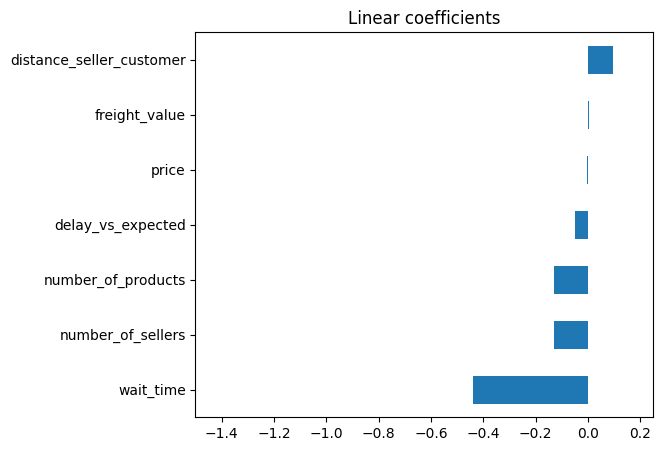

In [37]:
plt.figure(figsize=(13,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear coefficients')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1);

## Does wait time go down as the seller gets more experienced?

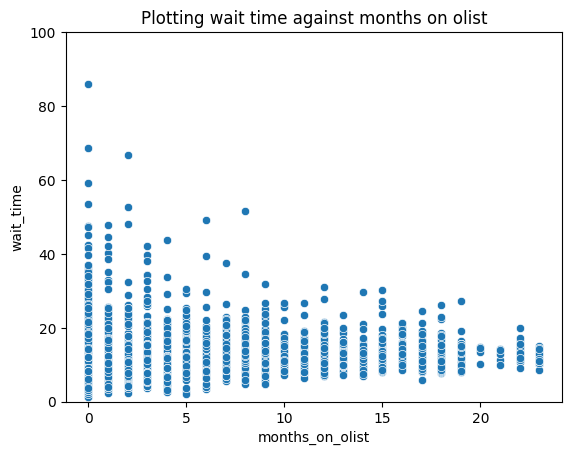

In [38]:
# sellers = Seller().get_training_data()
g = sns.scatterplot(data=sellers,x='months_on_olist',y='wait_time');
g.set_ylim(0,100)
g.set_title('Plotting wait time against months on olist');

## Is there a significant difference in wait time between the best and worst sellers?

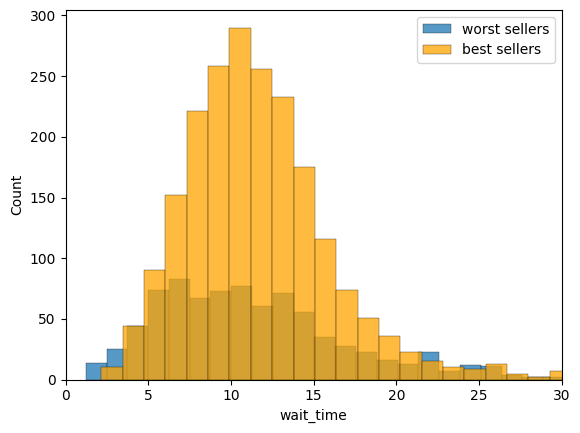

In [39]:
fig, (ax) = plt.subplots();
sns.histplot(ax=ax, data=worst_sellers,x='wait_time',bins=150,label='worst sellers');
sns.histplot(ax=ax, data=best_sellers,x='wait_time',bins=50, color='orange',label='best sellers');
ax.set_xlim(0,30)
ax.legend();